# Hackathon - Particle Images
## Problem Statement 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 



## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/content/Particle_Images


In [3]:
mkdir data/

# Download the Dataset

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2021-11-17 15:14:32--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  10.3MB/s    in 10s     

Last-modified header invalid -- time-stamp ignored.
2021-11-17 15:14:45 (8.19 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2021-11-17 15:14:45--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.28, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 798763

# Import modules

In [5]:
!pip install tensorflow-addons
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-beta1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.0.0-beta1


In [19]:
!pip install tfa
import numpy as np
np.random.seed(69)  # for reproducibility
import h5py
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from keras.utils.vis_utils import plot_model

# Load the TensorBoard notebook extension
%load_ext tensorboard

ERROR: Could not find a version that satisfies the requirement tfa (from versions: none)
ERROR: No matching distribution found for tfa
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Keras Model Parameters

In [7]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 50       # Training batch size
train_size  = 5000     # Training size 
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [8]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [9]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [10]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

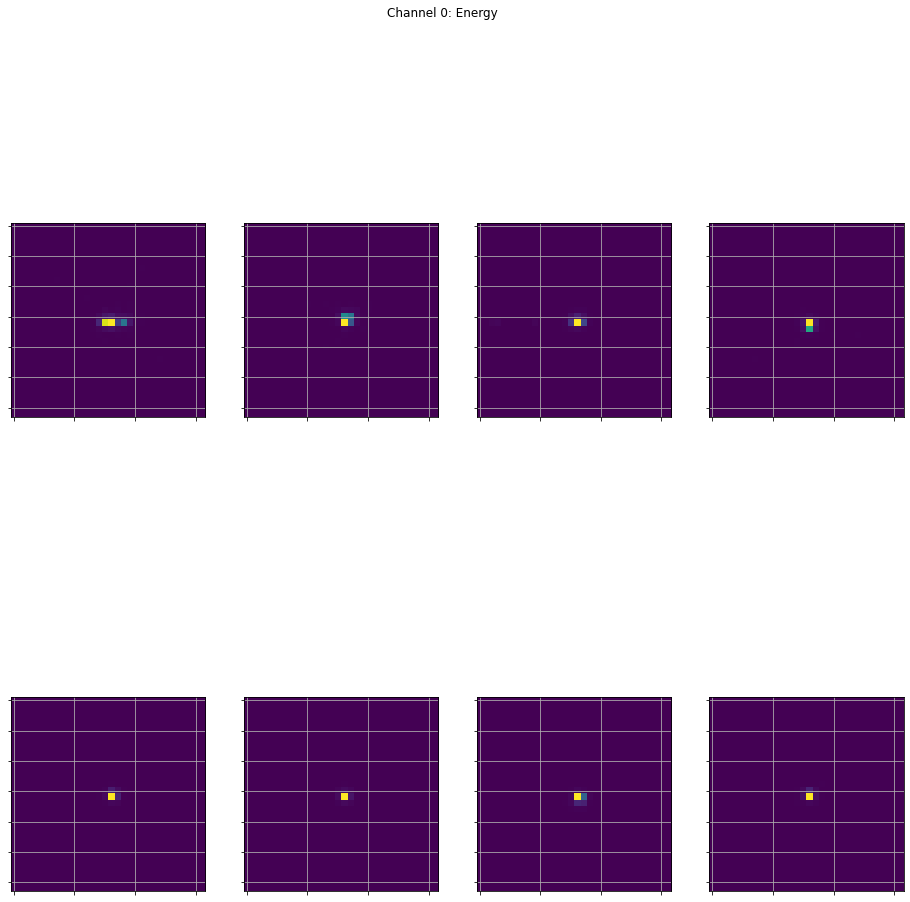

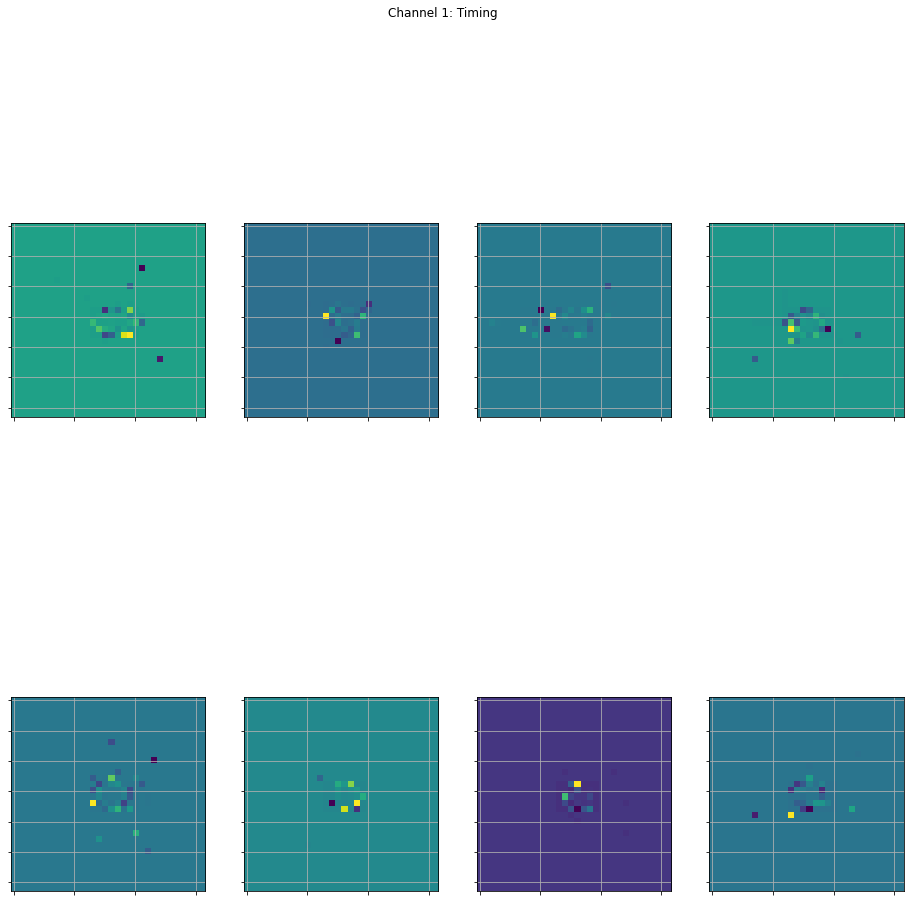

In [11]:
fig, ax = plt.subplots(2, 4,figsize=(16,16))
fig.suptitle("Channel 0: Energy")  # Energy
for i, axi in enumerate(ax.flat):
  axi.imshow(X_train[i,:,:,0])
  axi.grid(True)
  axi.set_xticklabels([])
  axi.set_yticklabels([])
  axi.set_aspect('equal')
  plt.subplots_adjust(wspace=None, hspace=None)

fig, ax = plt.subplots(2, 4,figsize=(16,16))
fig.suptitle("Channel 1: Timing")  # Timing
for i, axi in enumerate(ax.flat):
  axi.imshow(X_train[i,:,:,1])
  axi.grid(True)
  axi.set_xticklabels([])
  axi.set_yticklabels([])
  axi.set_aspect('equal')
  plt.subplots_adjust(wspace=None, hspace=None)



In [12]:
import tensorflow as tf
import tensorflow_addons as tfa


%reload_ext tensorboard
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""

    d = tf.distributions.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

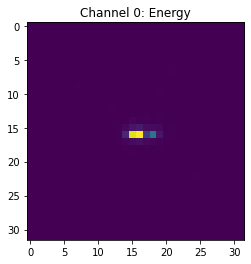

In [13]:
from tensorflow_addons.image import gaussian_filter2d
plt.title("Channel 0: Energy") 
plt.imshow(X_train[0,:,:,0])
kernelized_5 = gaussian_filter2d(X_train[0,:,:,0],filter_shape=2)
kernelized_3 = gaussian_filter2d(X_train[0,:,:,0],filter_shape=6)


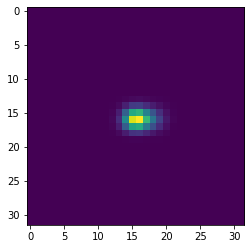

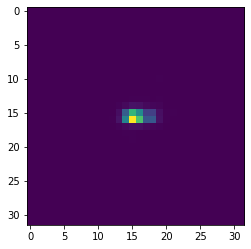

In [14]:
plt.imshow(kernelized_3)
plt.show()
plt.imshow(kernelized_5)

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [63]:
def naive_inception(input,filter_sizes=[40,60,80]):
  """
  input: previous layer's output
  filter_sizes: sizes of kernels (1x1,2x2,3x3)
  returns inception layer
  """
  #1x1 convolution
  layer_1 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  #2x2 convolution
  layer_2 = Conv2D(filters=filter_sizes[1], 
                  activation='relu', 
                  kernel_size=2,
                  padding='same')(input)
  #3x3 convolution
  layer_3 = Conv2D(filters=filter_sizes[2], 
                  activation='relu', 
                  kernel_size=3,
                  padding='same')(input)
  #2x2 max pooling
  layer_4 = AveragePooling2D(pool_size=2,strides=1,
                             padding='same')(input)

  mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
  return mid_1

def inception(input,filter_sizes=[80,40,20]):
  """
  input: previous layer's output
  filter_sizes: sizes of kernels (1x1,2x2,3x3)
  returns inception layer
  """
  #1x1 convolution
  layer_1 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  #2x2 convolution
  layer_2 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  layer_2 = Conv2D(filters=filter_sizes[1], 
                  activation='relu', 
                  kernel_size=2,
                  padding='same')(layer_2)
        
  #3x3 convolution
  layer_3 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  layer_3 = Conv2D(filters=filter_sizes[2], 
                  activation='relu', 
                  kernel_size=3,
                  padding='same')(layer_3)
  #2x2 max pooling
  layer_4 = AveragePooling2D(pool_size=2,strides=1,
                             padding='same')(input)
  layer_4 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(layer_4)

  mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
  return mid_1

In [ ]:
input_img = Input(shape=(img_rows, img_cols, nb_channels))

conv2d_1 = Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=3, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels))(input_img)
avg_pool_1 = AveragePooling2D(pool_size=2,strides=1)(conv2d_1)
conv2d_2 = Conv2D(strides=1,
                 filters=120, 
                 activation='relu', 
                 kernel_size=1, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels))(avg_pool_1)
avg_pool_2 = AveragePooling2D(pool_size=2,strides=2)(conv2d_2)
inception_naive_1 = naive_inception(avg_pool_2)
inception_naive_2 = naive_inception(inception_naive_1)
avg_pool_3 = AveragePooling2D(pool_size=2,strides=1)(inception_naive_2)
inception_naive_3 = naive_inception(avg_pool_3)
inception_naive_4 = naive_inception(inception_naive_3)
"""
avg_pool_3 = AveragePooling2D(pool_size=2,strides=1)(inception_naive_2)
inception_1 = inception(avg_pool_3,filter_size=200)
inception_2 = inception(inception_1,filter_size=200)
inception_3 = inception(inception_2,filter_size=200)
inception_4 = inception(inception_3,filter_size=300)
avg_pool_4 = AveragePooling2D(pool_size=2)(inception_4)
inception_5 = inception(avg_pool_4,filter_size=300)
inception_6 = inception(inception_5,filter_size=400)
avg_pool_5 = AveragePooling2D(pool_size=2)(inception_6)
"""
avg_pool_5 = AveragePooling2D(pool_size=2)(inception_naive_4)
flat_1 = Flatten()(avg_pool_5)
dropout_1 = Dropout(0.2)(flat_1)
dense_1 = Dense(400,activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(dense_1)
output = Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal')(dropout_2)
model = Model([input_img],output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])

plot_model(model,show_shapes=True,show_layer_names=True)
model.summary()

In [68]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/20
200/200 [==============================] - 27s 123ms/step - loss: 0.6928 - accuracy: 0.5004 - val_loss: 0.6915 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 25s 124ms/step - loss: 0.6857 - accuracy: 0.5506 - val_loss: 0.6784 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 24s 118ms/step - loss: 0.6664 - accuracy: 0.5916 - val_loss: 0.6622 - val_accuracy: 0.6099 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 24s 119ms/step - loss: 0.6578 - accuracy: 0.6065 - val_loss: 0.6597 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 24s 119ms/step - loss: 0.6542 - accuracy: 0.6153 - val_loss: 0.6595 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 24s 119ms/step - loss: 0.6530 - accuracy: 0.6175 - val_loss: 0.6591 - val_accuracy: 0.6143 - lr: 0.0010
Epoch 7/20
200/200 [==============================] 

## Train the Model
### You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [69]:
"""
# Evaluate on training set
score = model.evaluate(X_train, y_train, verbose=1)
print('\nTraining loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_train)
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
print('Training ROC AUC:', roc_auc)
"""

# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

64/64 [==============================] - 3s 26ms/step - loss: 0.6287 - accuracy: 0.6567

Validation loss / accuracy: 0.6287 / 0.6567
Validation ROC AUC: 0.6936278343200684
64/64 [==============================] - 2s 25ms/step - loss: 0.6304 - accuracy: 0.6494

Test loss / accuracy: 0.6304 / 0.6494
Test ROC AUC: 0.6892166137695312


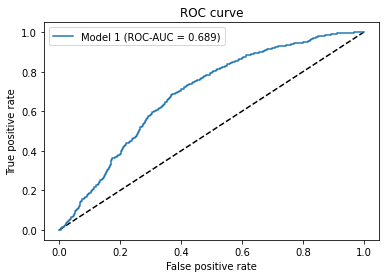

In [70]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#ROC-AUC

# Submission format: 
### Please submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). You are free to choose Machine Learning Framework of your choice. 

#Tests

In [67]:
input_img = Input(shape=(img_rows, img_cols, nb_channels))

conv2d_1 = Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=3, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels))(input_img)
avg_pool_1 = AveragePooling2D(pool_size=2,strides=1)(conv2d_1)
conv2d_2 = Conv2D(strides=1,
                 filters=120, 
                 activation='relu', 
                 kernel_size=1, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels))(avg_pool_1)
avg_pool_2 = AveragePooling2D(pool_size=2,strides=2)(conv2d_2)
inception_naive_1 = naive_inception(avg_pool_2)
inception_naive_2 = naive_inception(inception_naive_1)
avg_pool_3 = AveragePooling2D(pool_size=2,strides=1)(inception_naive_2)
inception_naive_3 = naive_inception(avg_pool_3)
inception_naive_4 = naive_inception(inception_naive_3)
"""
avg_pool_3 = AveragePooling2D(pool_size=2,strides=1)(inception_naive_2)
inception_1 = inception(avg_pool_3,filter_size=200)
inception_2 = inception(inception_1,filter_size=200)
inception_3 = inception(inception_2,filter_size=200)
inception_4 = inception(inception_3,filter_size=300)
avg_pool_4 = AveragePooling2D(pool_size=2)(inception_4)
inception_5 = inception(avg_pool_4,filter_size=300)
inception_6 = inception(inception_5,filter_size=400)
avg_pool_5 = AveragePooling2D(pool_size=2)(inception_6)
"""
avg_pool_5 = AveragePooling2D(pool_size=2)(inception_naive_4)
flat_1 = Flatten()(avg_pool_5)
dropout_1 = Dropout(0.2)(flat_1)
dense_1 = Dense(400,activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(dense_1)
output = Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal')(dropout_2)
model = Model([input_img],output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])

plot_model(model,show_shapes=True,show_layer_names=True)
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 32, 32, 2)]  0           []                               
                                                                                                  
 conv2d_369 (Conv2D)            (None, 32, 32, 40)   760         ['input_34[0][0]']               
                                                                                                  
 average_pooling2d_156 (Average  (None, 31, 31, 40)  0           ['conv2d_369[0][0]']             
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_370 (Conv2D)            (None, 31, 31, 120)  4920        ['average_pooling2d_156[0]

In [20]:
### Define Convolutional Neural Network (CNN) Model ###
model = Sequential()
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=3, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())


model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(strides=1,
                 filters=48, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=48, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(strides=1,
                 filters=56, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=56, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
#model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())


model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 40)        760       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 40)       0         
 ooling2D)                                                       
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 40)        6440      
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 8, 40)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 40)          6440      
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 40)          6

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#ROC-AUC

In [ ]:
model = Sequential()
model.add(Conv2D(16, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='elu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()